In [1]:
import numpy as np
import cPickle as pickle
import datetime
import os
from collections import Counter

import keras
from sklearn.naive_bayes import MultinomialNB
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras import losses
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
import sklearn.preprocessing

from sklearn.manifold import TSNE
from tsne import plot_with_labels


from utils import generate_data_for_labels, read_pickle

Using TensorFlow backend.


In [2]:
BASE_DIR = '/mnt/disks/sup/finetune/'
PROJECTION_DIMS = 256
PREFIX = 'alternating-' + str(PROJECTION_DIMS) + '-kl'
MOST_COMMON = 4

In [3]:
def build_model(input_shape, n_classes):
    model = Sequential()
    model.add(
        Dense(PROJECTION_DIMS, input_shape=input_shape)
    )
    model.add(
        Dense(n_classes, activation='softmax')
    )
    return model


def get_callbacks(prefix, base_dir):
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')
    log_dir = base_dir + 'logs/{}_{}/'.format(prefix, timestamp)
    print('log_dir {}'.format(log_dir))
    model_checkpoint_dir = base_dir + 'models/{}_{}/'.format(prefix, timestamp)

    if not os.path.exists(log_dir):
        os.makedirs(log_dir)

    if not os.path.exists(model_checkpoint_dir):
        os.makedirs(model_checkpoint_dir)

    # build a tensorboard callback object using the above log dir
    tensorboard_callback = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_images=False
    )
    # # build a model checkpoint callback object using the above model checkpoint dir
    checkpoint_callback = ModelCheckpoint(
        model_checkpoint_dir + 'best_weights.hdf5',
        monitor='val_loss',
        verbose=0,
        save_best_only=True,
        save_weights_only=True,
        mode='auto'
    )
    early_stopping_callback = EarlyStopping(patience=8)

    return [checkpoint_callback, tensorboard_callback, early_stopping_callback]


In [4]:
def get_pd(x, y):
    xn = (x - x.min(0)) / x.ptp(0)
    clf = MultinomialNB()
    clf.fit(xn, y)
    return clf.predict_proba(xn)

In [5]:
def fetch_inputs():
    videos_savepath = BASE_DIR + 'save_videos.pkl'
    
    audios_savepath = BASE_DIR + 'save_audios.pkl'

    labels_savepath = BASE_DIR + 'save_labels.pkl'

    original_labels_savepath = BASE_DIR + 'save_original_labels.pkl'
    
    with open(videos_savepath, 'rb') as vsp:
        videos = pickle.load(vsp)
    
    with open(audios_savepath, 'rb') as asp:
        audios = pickle.load(asp)

    with open(labels_savepath, 'rb') as lsp:
        labels = pickle.load(lsp)

    with open(original_labels_savepath, 'rb') as olsp:
        original_labels = pickle.load(olsp)
        
    return videos, audios, labels, original_labels 

In [6]:
def minimize_classification_err(model, X, Y, i):
    model.compile(
        loss=losses.categorical_crossentropy,
        optimizer=Adam(lr=1e-3)
    )
    epochs_1 = 150
    hist1 = model.fit(
        X, Y,
        epochs=epochs_1,
        verbose=1,
        validation_split=0.15,
        callbacks=get_callbacks('{}_{}_clf'.format(PREFIX, i), './basedir/')
    )
    return model, hist1

In [7]:
def minimize_kld(model, X, pd_X, Y, i):
    model.compile(
        optimizer=Adam(lr=1e-4),
        loss=losses.kld
    )
    pd = get_pd(pd_X, Y)
    epochs_2 = 150
    hist2 = model.fit(
        X,
        pd,
        epochs=epochs_2,
        validation_split=0.15,
        callbacks=get_callbacks('{}_{}_kld'.format(PREFIX, i), './basedir/')
    )
    return model, hist2

In [8]:
def run_alternating(max_iter):
    videos, audios, labels, original_labels = fetch_inputs()
    print('------- loaded data -------')
    
    concat = np.hstack([videos, audios])
    input_shape = (concat.shape[1],)
    model = build_model(input_shape, MOST_COMMON)
    print('------- built model -------')
    
    for i in range(max_iter):
        print('------- minimizing classification error -------')
        model.layers[0].trainable = False
        model.layers[-1].trainable = True
        model, hist_clf = minimize_classification_err(model, concat, labels, i)
        
        print('------- minimizing kl divergence -------')
        model.layers[0].trainable = True
        model.layers[-1].trainable = False
        model, hist_kld = minimize_kld(model, concat, audios, original_labels, i)
        
    return model, videos, audios, labels, original_labels, concat

In [9]:
model, videos, audios, labels, original_labels, concat = run_alternating(3)

In [10]:
def get_projected_representation(model, X):
    get_first_output = keras.backend.function([model.layers[0].input], [model.layers[0].output])
    first_output = get_first_output([X])[0]
    return first_output

In [11]:
projected = get_projected_representation(model, concat)

In [12]:
def save_projected(projected, model, original_labels):
    projected_path = './basedir/' + PREFIX + '_projected.pkl'
    labels_path = './basedir/' + PREFIX + '_labels.pkl'
    model_path = './basedir/' + PREFIX + '_model.h5'
    
    with open(projected_path, 'wb') as pp:
        pickle.dump(projected, pp)
        
    with open(labels_path, 'wb') as lp:
        pickle.dump(original_labels, lp)
        
    model.save(model_path)

In [13]:
save_projected(projected, model, original_labels)

In [14]:
def plot_tsne(x, y, title):
    tsne_sklearn = TSNE()
    np.set_printoptions(suppress=True)
    x_2 = tsne_sklearn.fit_transform(x, y)
    plot_with_labels(x_2, y, title)

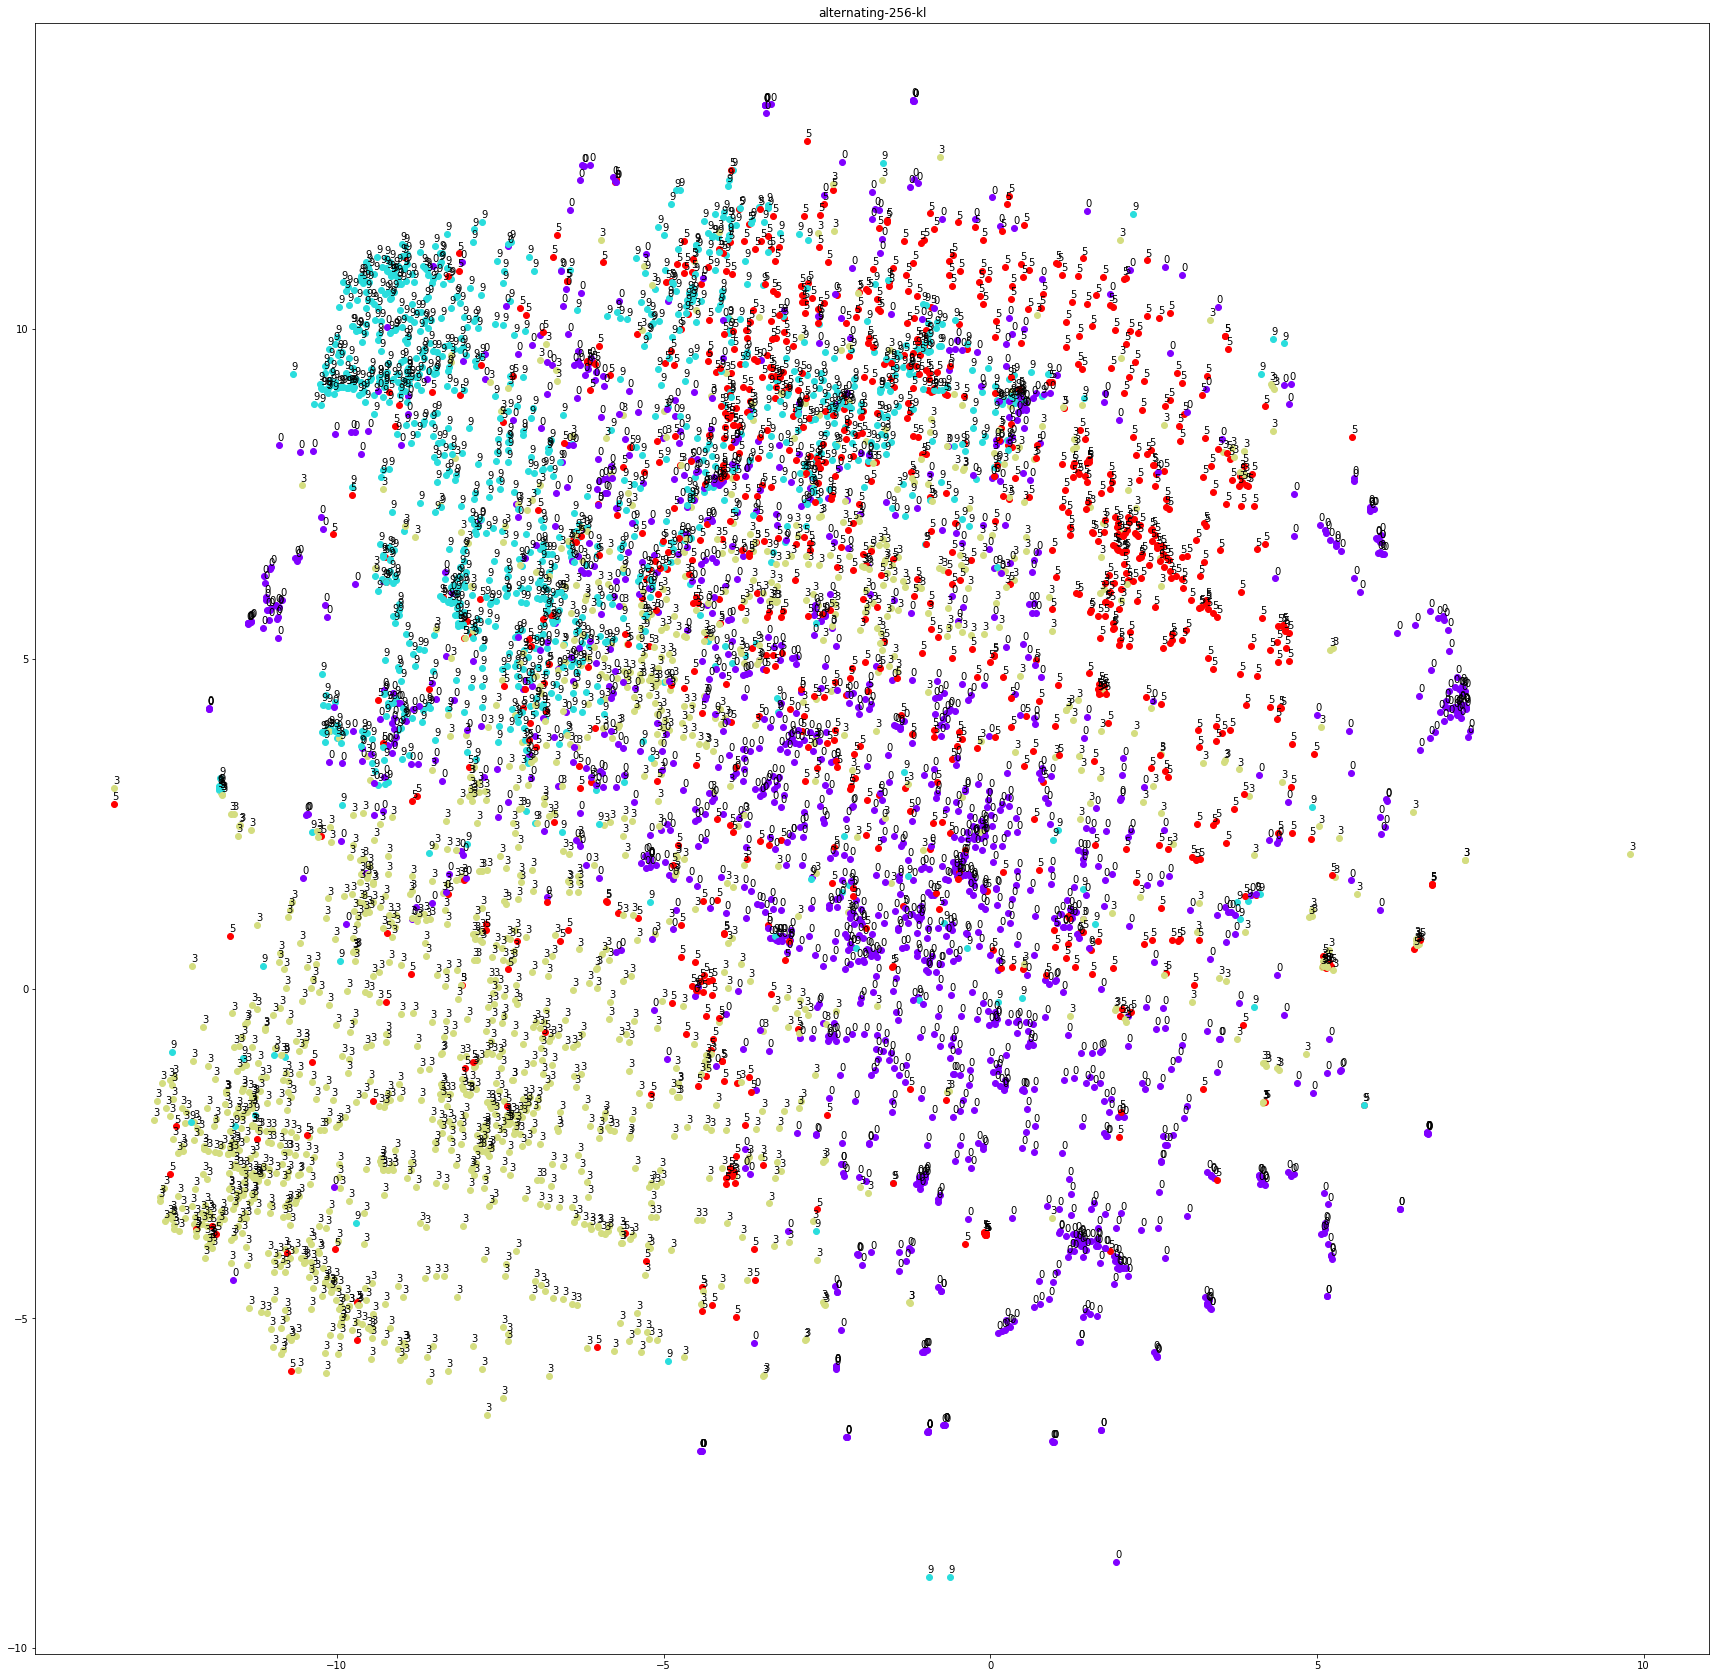

In [15]:
import random
N = len(videos)
selection_size = 5000
sel = random.sample(range(N), selection_size)
x_sample = projected[sel]
labels_sample = original_labels[sel]

plot_tsne(x_sample, labels_sample, PREFIX)